# CAP 6615 Neural Networks Programming Assignment 1 – Single Layer Perceptron

### Keyuan Lu, Wenxuan Bao, Yiming Xu, Yufan Chen, Yue Bai

In [1]:
# import packages
from PIL import Image
import numpy as np
import itertools
from matplotlib import pyplot as plt
import random 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib.lines import Line2D
import pandas as pd

## Step 1 - Design and build a dataset $X$ for character recognition of 20 16x16-pixel images (256 pixels per image) from online exemplars.

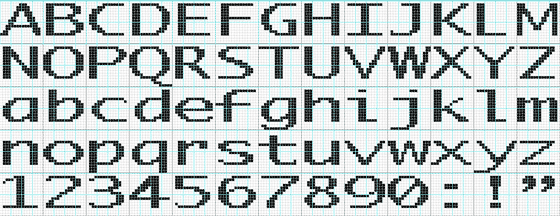

In [2]:
# you can download this 'alphabet.gif' directly from the programming assignment page on Canvas.
im = Image.open('alphabet.gif')
im

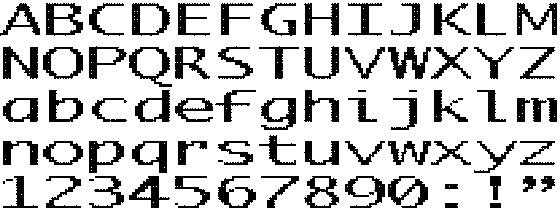

In [3]:
# convert image to black and white
im = im.convert('1')
im

In [4]:
w, h = im.size
print('width: ', w)
print('height:', h)

width:  560
height: 216


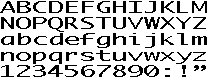

In [5]:
#resize the image
image_height = 16
image_width = 16
m = 13
n = 5
image_size = image_height*image_width
im_resize = im.resize((m*image_width, n*image_height))
im_resize

In [6]:
#check the resize image and change data type
pix = np.array(im_resize)
nrow, ncol = pix.shape
print(pix.shape)
print(pix.dtype)
# change the data type from bool to double
pix = pix.astype(np.float32)
print(pix.dtype)

(80, 208)
bool
float32


In [7]:
# construct the dataset 
n_sample = 20
n_channel  = 1
dataset = np.ndarray(shape=(n_sample, n_channel, image_height, image_width), dtype=np.float32)
dataset.shape
dataset.dtype
idx = 0
for i in range(5):
    for j in range(13):
        if( (i == 0 or i == 4) and ( 0 <= j <= 9) ):
            x = pix[(i*image_height):( (i+1)*image_height), (j*image_width):( (j+1)*image_width)]
            dataset[idx] = x
            idx += 1
print("All images to array!")
dataset.shape

All images to array!


(20, 1, 16, 16)

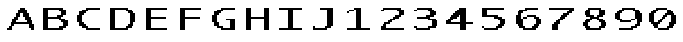

In [8]:
# display all 20 images in the dataset
fig, axs = plt.subplots(1, 20 ,figsize=(12,12))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset):
        ax.imshow(dataset[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

In [9]:
# flatten the data
dataset_reshaped = dataset.reshape((n_sample, 1, -1))
dataset_reshaped.shape

(20, 1, 256)

In [10]:
#construct lables of images
labels = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
         '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] )
len(labels)
labels

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '0'], dtype='<U1')

In [11]:
# randomly select 10 images as training set
random.seed(1)
lst = list(range(n_sample))
index = random.sample(lst, n_sample//2)
print(index) 
dataset_train  = dataset[index]
labels_train  = labels[index]
labels_train

[4, 18, 2, 8, 3, 7, 12, 14, 13, 10]


array(['E', '9', 'C', 'I', 'D', 'H', '3', '5', '4', '1'], dtype='<U1')

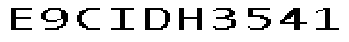

In [12]:
# display 10 images in the training dataset
fig, axs = plt.subplots(1, n_sample//2 ,figsize=(6,6))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_train):
        ax.imshow(dataset_train[i, 0], cmap='gray', interpolation='nearest')
        ax.axis('off')
        #one save images to jepg image files
        temp = Image.fromarray(dataset_train[i, 0].astype('uint8')*255, "L")
        #temp.save("training_" + str(i) + ".jpeg")
    else:
        ax.remove()
plt.show()

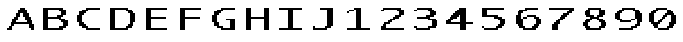

In [13]:
#display test dataset (including images in the training set!)
fig, axs = plt.subplots(1, n_sample ,figsize=(12,12))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset):
        ax.imshow(dataset[i, 0], cmap='gray', interpolation='nearest')
        ax.axis('off')
        #one save images to jepg image files
        temp = Image.fromarray(dataset[i, 0].astype('uint8')*255, "L")
        #temp.save("test_" + str(i) + ".jpeg")
    else:
        ax.remove()
plt.show()

## Step 2 - Design and develop a single-layer perceptron (SLP) in Python, using libraries such as PyTorch (and, if necessary, Tensor Flow). 

### Approach 1: Simple Network with Scalar Output: 

In [14]:
class TrainableEltwiseLayer(nn.Module):
    def __init__(self,D_in):
        super(TrainableEltwiseLayer, self).__init__()
        self.weights = nn.Parameter(torch.randn(D_in))  # define the trainable parameter
    def forward(self, x):
        # assuming x is of size b-1-h-w
        return torch.sum(x * self.weights) + 1

In [15]:
model1 = TrainableEltwiseLayer(256)

### Approach 2: Simple Network with Vector Output

In [16]:
class TrainableVectorLayer(nn.Module):
    def __init__(self,D_in,D_out):
        super(TrainableVectorLayer, self).__init__()
        self.linear = nn.Linear(D_in,D_out)
        self.acti = nn.Sigmoid()
    def forward(self, x):
        outs = self.linear(x)
        res = self.acti(outs)
        return res

In [17]:
model2 = TrainableVectorLayer(256, 20)

### Approach 3: Fully-connected Network with Image Output:  

In [18]:
# Use the nn package to define our model
model3 = torch.nn.Sequential(
    nn.Linear(256, 256),
    nn.Sigmoid()
)
model3

Sequential(
  (0): Linear(in_features=256, out_features=256, bias=True)
  (1): Sigmoid()
)

## Step 3 - Train your SLP on a representative subset (10 images that your group selects and documents) from the 20-image dataset developed in 1), above.  

In [19]:
dataset_train_reshaped = dataset_train.reshape((n_sample//2, 1, -1))

### train model 1

In [20]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
y_train_label = [x+1 for x in index]
model1 = TrainableEltwiseLayer(256)
# define loss function.
loss_fn = nn.MSELoss()
# Use the optim package to define an Optimizer that will update the weights of the model for us. 
learning_rate = 1e-3
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
for t in range (600):
    for i, data in enumerate(dataset_train_reshaped):
        y = torch.from_numpy(np.array(y_train_label[i])).float()
        x = torch.from_numpy(data).float()
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model1(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        if (i % 10 == 0 ) and (t % 10 == 0 ):
            print("Epoch {} - loss: {}".format(t, loss.item()))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

Epoch 0 - loss: 164.3692626953125
Epoch 10 - loss: 107.33344268798828
Epoch 20 - loss: 84.72238159179688
Epoch 30 - loss: 66.58934783935547
Epoch 40 - loss: 51.752159118652344
Epoch 50 - loss: 39.686519622802734
Epoch 60 - loss: 29.978553771972656
Epoch 70 - loss: 22.26321792602539
Epoch 80 - loss: 16.216371536254883
Epoch 90 - loss: 11.550025939941406
Epoch 100 - loss: 8.011482238769531
Epoch 110 - loss: 5.381706237792969
Epoch 120 - loss: 3.472996950149536
Epoch 130 - loss: 2.1272010803222656
Epoch 140 - loss: 1.2126374244689941
Epoch 150 - loss: 0.6214672923088074
Epoch 160 - loss: 0.26682838797569275
Epoch 170 - loss: 0.0798325389623642
Epoch 180 - loss: 0.006900988053530455
Epoch 190 - loss: 0.007221440318971872
Epoch 200 - loss: 0.050445087254047394
Epoch 210 - loss: 0.11467655003070831
Epoch 220 - loss: 0.1847313493490219
Epoch 230 - loss: 0.2506202757358551
Epoch 240 - loss: 0.30630385875701904
Epoch 250 - loss: 0.34868502616882324
Epoch 260 - loss: 0.3767516613006592
Epoch 270

### train model 2

In [21]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
model2 = TrainableVectorLayer(256, 20)
# define loss function.
loss_fn = nn.BCELoss()
learning_rate = 1e-3
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
for t in range (600):
    for i, data in enumerate(dataset_train_reshaped):
        x = torch.from_numpy(data).float()
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model2(x)[0]
        y = [0] * 20
        y[y_train_label[i]-1] = 1
        y = torch.tensor(y).float()
        loss = loss_fn(y_pred,y)
        if (i % 10 == 0 ) and (t % 10 == 0 ):
            print("Epoch {} - loss: {}".format(t, loss.item()))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). 
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

Epoch 0 - loss: 0.6878867745399475
Epoch 10 - loss: 0.11582133919000626
Epoch 20 - loss: 0.0689687430858612
Epoch 30 - loss: 0.04350609332323074
Epoch 40 - loss: 0.0300426185131073
Epoch 50 - loss: 0.022187504917383194
Epoch 60 - loss: 0.017169388011097908
Epoch 70 - loss: 0.013739636167883873
Epoch 80 - loss: 0.011275217868387699
Epoch 90 - loss: 0.00943552516400814
Epoch 100 - loss: 0.008020387962460518
Epoch 110 - loss: 0.006905141286551952
Epoch 120 - loss: 0.006008519791066647
Epoch 130 - loss: 0.005275505594909191
Epoch 140 - loss: 0.004667617846280336
Epoch 150 - loss: 0.0041572824120521545
Epoch 160 - loss: 0.003724255133420229
Epoch 170 - loss: 0.003353328676894307
Epoch 180 - loss: 0.0030329739674925804
Epoch 190 - loss: 0.0027542277239263058
Epoch 200 - loss: 0.0025100826751440763
Epoch 210 - loss: 0.002294961828738451
Epoch 220 - loss: 0.0021043955348432064
Epoch 230 - loss: 0.0019347412744536996
Epoch 240 - loss: 0.0017830440774559975
Epoch 250 - loss: 0.001646836288273334

### train model 3

Epoch 0 - loss: 0.2717939019203186
Epoch 10 - loss: 0.061454787850379944
Epoch 20 - loss: 0.03661039471626282
Epoch 30 - loss: 0.02388944663107395
Epoch 40 - loss: 0.016695624217391014
Epoch 50 - loss: 0.012255598790943623
Epoch 60 - loss: 0.009343702346086502
Epoch 70 - loss: 0.007341778837144375
Epoch 80 - loss: 0.005911341402679682
Epoch 90 - loss: 0.004855836741626263
Epoch 100 - loss: 0.00405559316277504
Epoch 110 - loss: 0.003434748388826847
Epoch 120 - loss: 0.002943495288491249
Epoch 130 - loss: 0.0025481178890913725
Epoch 140 - loss: 0.0022251680493354797
Epoch 150 - loss: 0.0019579457584768534
Epoch 160 - loss: 0.0017343034269288182
Epoch 170 - loss: 0.0015452370280399919
Epoch 180 - loss: 0.0013839583843946457
Epoch 190 - loss: 0.0012452731607481837
Epoch 200 - loss: 0.0011251495452597737
Epoch 210 - loss: 0.0010204218560829759
Epoch 220 - loss: 0.0009285737760365009
Epoch 230 - loss: 0.0008475857903249562
Epoch 240 - loss: 0.0007758209831081331
Epoch 250 - loss: 0.000711941

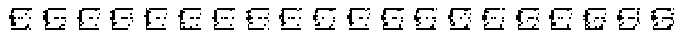

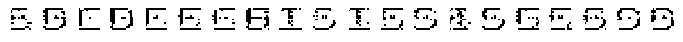

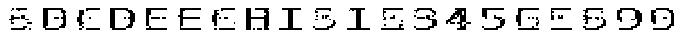

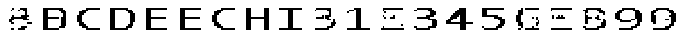

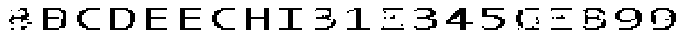

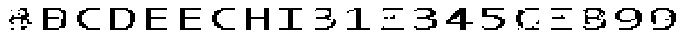

In [22]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
# Use the nn package to define our model
# Fully-connected Network 
model3 = torch.nn.Sequential(
    nn.Linear(256, 256),
    nn.Sigmoid()
)
# define loss function.
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = optim.Adam(model3.parameters(), lr=learning_rate)
loss_all = []
for t in range (600):
    for i, data in enumerate(dataset_train_reshaped):
        y = torch.from_numpy(data)
        x = torch.from_numpy(data)
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model3(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)      
        if (i % 10 == 0 ) and (t % 10 == 0 ):
            print("Epoch {} - loss: {}".format(t, loss.item()))
            
        if (i % 10 == 0 ):
            loss_all += [loss]            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i % 10 == 9 ) and (t in [ 0, 4, 9, 49, 99 ,199] ):
            fig, axs = plt.subplots(1, n_sample ,figsize=(12, 12))
            for j, data_j in enumerate(dataset_reshaped):
                x = torch.from_numpy(data_j)
                output = model3(x)
                output[output > 0.5] = 1
                output[output <= 0.5] = 0
                pred = output.detach().numpy()
                pred = pred.reshape((image_height, image_width ))
                ax = axs.flatten()[j]
                ax.imshow(pred, cmap='gray', interpolation='nearest')
                ax.axis('off')

Text(0, 0.5, 'MSEloss')

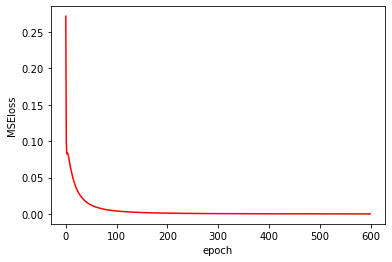

In [23]:
plt.plot(np.array(loss_all), 'r')
plt.xlabel("epoch")
plt.ylabel("MSEloss")

## Step 4 - Test your SLP on the entire 20-image dataset developed in 1), above -- with no noise introduced into the input dataset

In [24]:
# test approach 1
dataset_labels =np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] ) 
cor = 0
for i, data in enumerate(dataset_reshaped):
    x = torch.from_numpy(data)
    label = dataset_labels[i]
    out =round(model1(x).float().item())
    if out < 1:
        out = 1
    if out > 20:
        out = 20
    if out == label:
        cor += 1 
    print("answer: {},output {}".format(label, out))
print("accuracy:{}".format(cor/20))

answer: 1,output 6
answer: 2,output 1
answer: 3,output 3
answer: 4,output 4
answer: 5,output 5
answer: 6,output 3
answer: 7,output 1
answer: 8,output 8
answer: 9,output 9
answer: 10,output 20
answer: 11,output 11
answer: 12,output 10
answer: 13,output 13
answer: 14,output 14
answer: 15,output 15
answer: 16,output 9
answer: 17,output 14
answer: 18,output 7
answer: 19,output 19
answer: 20,output 15
accuracy:0.5


In [25]:
# test approach 2
cor = 0
for i, data in enumerate(dataset_reshaped):
    x = torch.from_numpy(data)
    label = dataset_labels[i]
    out = torch.argmax(model2(x)) + 1
    if out == label:
        cor += 1 
    print("answer: {},output {}".format(label, out))
print("accuracy:{}".format(cor/20))

answer: 1,output 14
answer: 2,output 4
answer: 3,output 3
answer: 4,output 4
answer: 5,output 5
answer: 6,output 5
answer: 7,output 3
answer: 8,output 8
answer: 9,output 9
answer: 10,output 13
answer: 11,output 11
answer: 12,output 13
answer: 13,output 13
answer: 14,output 14
answer: 15,output 15
answer: 16,output 3
answer: 17,output 9
answer: 18,output 13
answer: 19,output 19
answer: 20,output 19
accuracy:0.5


In [26]:
#Compute metrics (described below) called fraction-of-hits (Fh) and fraction-of-false-alarms (Ffa)
# 0 -- black
# 1 -- white
def metrics_naive(target, pred):
    Fh = (sum( (i == j) and (i == 0)  for i, j in zip(target, pred)) )/ sum(target == 0)
    Ffa = (sum( (i != j) and (i == 1)  for i, j in zip(target, pred)) )/ sum(target == 1)
    return Fh, Ffa

In [27]:
#Compute metrics 
def metrics(target, pred):
    Fh = sum((target == 0) & (target == pred))/ sum(target == 0)
    Ffa = sum((target == 1) & (target != pred))/ sum(target == 1)
    return Fh, Ffa

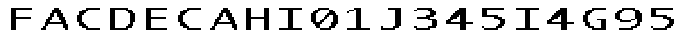

In [28]:
# model 1
Fh_res = []
Ffa_res = []
fig, axs = plt.subplots(1, n_sample ,figsize=(12, 12))
for i, data in enumerate(dataset_reshaped):
    x = torch.from_numpy(data)
    label = dataset_labels[i]
    out =round(model1(x).float().item())
    if out < 1:
        out = 1
    if out > 20:
        out = 20
    pred = dataset_reshaped[out-1, 0]
    pred = pred.reshape((image_height, image_width ))
    ax = axs.flatten()[i]
    ax.imshow(pred, cmap='gray', interpolation='nearest')
    ax.axis('off')
    x = x.flatten().detach().numpy()
    y = pred.flatten()
    Fh, Ffa = metrics(x, y)
    Fh_res+= [Fh]
    Ffa_res+= [Ffa]

Text(0, 0.5, 'Fh')

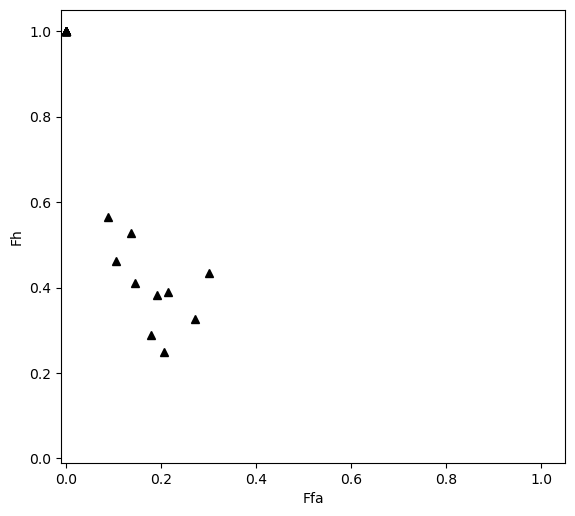

In [29]:
plt.figure(figsize=[6.5,6],dpi=100)
plt.plot(Ffa_res, Fh_res, '^', color='black');
plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)
plt.xlabel("Ffa")
plt.ylabel("Fh")

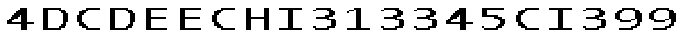

In [30]:
# model 2
Fh_res = []
Ffa_res = []
fig, axs = plt.subplots(1, n_sample ,figsize=(12, 12))
for i, data in enumerate(dataset_reshaped):
    x = torch.from_numpy(data)
    label = dataset_labels[i]
    out = torch.argmax(model2(x)) + 1
    pred = dataset_reshaped[out-1, 0]
    pred = pred.reshape((image_height, image_width ))
    ax = axs.flatten()[i]
    ax.imshow(pred, cmap='gray', interpolation='nearest')
    ax.axis('off')
    x = x.flatten().detach().numpy()
    y = pred.flatten()
    Fh, Ffa = metrics(x, y)
    Fh_res+= [Fh]
    Ffa_res+= [Ffa]

Text(0, 0.5, 'Fh')

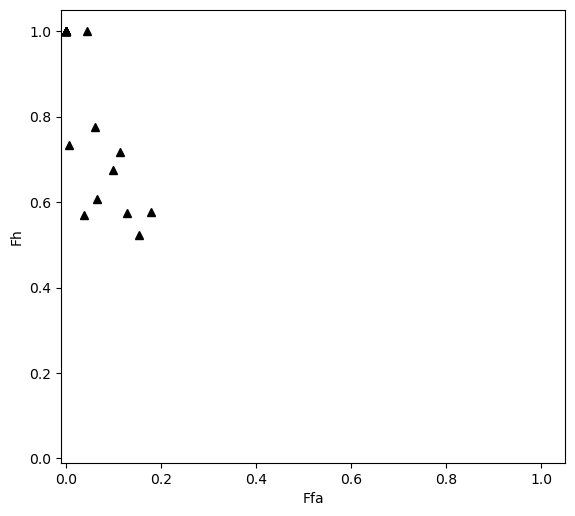

In [31]:
plt.figure(figsize=[6.5,6],dpi=100)
plt.plot(Ffa_res, Fh_res, '^', color='black');
plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)
plt.xlabel("Ffa")
plt.ylabel("Fh")

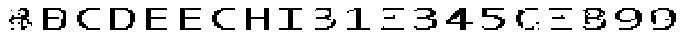

In [32]:
#model 3
Fh_res = []
Ffa_res = []
fig, axs = plt.subplots(1, n_sample ,figsize=(12, 12))
for i, data in enumerate(dataset_reshaped):
    x = torch.from_numpy(data)
    output = model3(x)
    output[output > 0.5] = 1
    output[output <= 0.5] = 0
    pred = output.detach().numpy()
    pred = pred.reshape((image_height, image_width ))
    ax = axs.flatten()[i]
    ax.imshow(pred, cmap='gray', interpolation='nearest')
    ax.axis('off')
    x = x.flatten().detach().numpy()
    y = output.flatten().detach().numpy()
    Fh, Ffa = metrics(x, y)
    Fh_res+= [Fh]
    Ffa_res+= [Ffa]

In [33]:
# Fh_res

In [34]:
# Ffa_res

Text(0, 0.5, 'Fh')

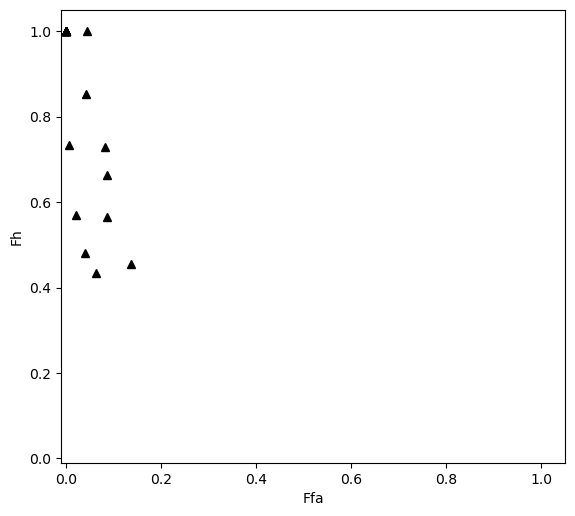

In [35]:
plt.figure(figsize=[6.5,6],dpi=100)
plt.plot(Ffa_res, Fh_res, '^', color='black');
plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)
plt.xlabel("Ffa")
plt.ylabel("Fh")
# plt.savefig('Fh_Ffa_noiseless.eps')

## Step 5 - Perturb your dataset (from 1), above) by adding noise

In [36]:
# standard deviation
sd = [0.0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]

In [37]:
dataset_reshaped.shape

(20, 1, 256)

In [38]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(len(dataset)):
        s = np.random.normal(0, sigma, 25)
        index = random.sample(list(range(256)), 25)
        dataset_noise[i] = dataset[i]    
        dataset_noise[i, 0, index] = dataset_noise[i, 0, index] + s
        dataset_noise[i,0] = NormalizeData(dataset_noise[i,0 ])
    return dataset_noise   

## Step 6 -  Repeat Tests in Step 4), above, and gather the results into a table of Fh and Ffa versus test-image-ID, with one row for each value of the standard deviation

### In this part, we only report the result of Fh and Ffa by approach 3

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


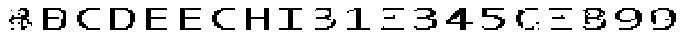

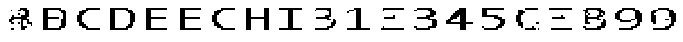

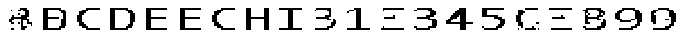

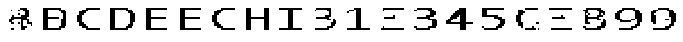

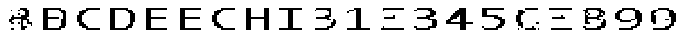

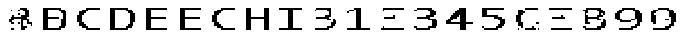

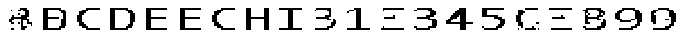

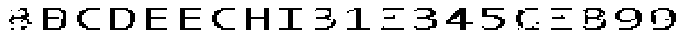

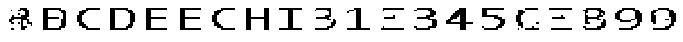

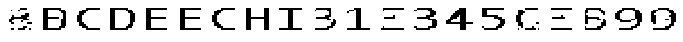

In [39]:
Fh_res_all = []
Ffa_res_all = []
for sigma in sd:
    print(sigma)
    dataset_noise = NoiseData(dataset_reshaped, sigma)
    # test results
    Fh_res = []
    Ffa_res = []
    fig, axs = plt.subplots(1, n_sample ,figsize=(12, 12))
    for i, data in enumerate(dataset_noise):
        x = torch.from_numpy(data)
        output = model3(x)
        output[output > 0.5] = 1
        output[output <= 0.5] = 0
        pred = output.detach().numpy()
        pred = pred.reshape((image_height, image_width ))
        ax = axs.flatten()[i]
        ax.imshow(pred, cmap='gray', interpolation='nearest')
        ax.axis('off')
        x = dataset_reshaped[i].reshape([-1])
        y = output.flatten().detach().numpy()
        Fh, Ffa = metrics(x, y)
        Fh_res+= [Fh]
        Ffa_res+= [Ffa]
    Fh_res_all.append(Fh_res)
    Ffa_res_all.append(Ffa_res)

Text(0.5, 1.0, 'Graph of Fh and Ffa vs. Noise Standard Deviation\n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for Autoassociative Single-Layer Perceptron')

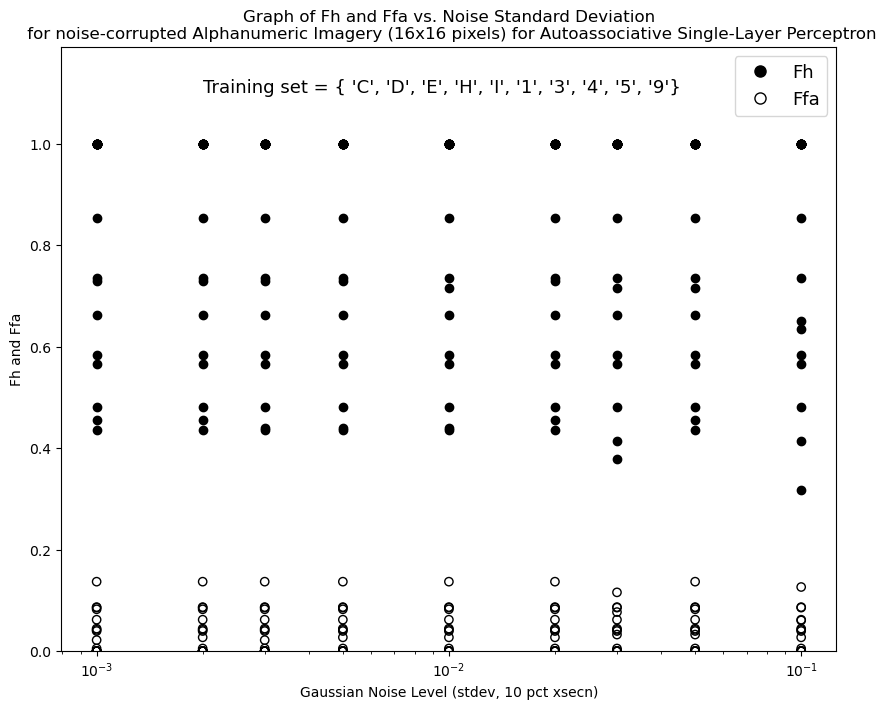

In [40]:
plt.figure(figsize=[10,8],dpi=100)
for i in range(1, len(sd)):
    plt.plot([sd[i]]*n_sample, Fh_res_all[i],'o', color='black')
    plt.scatter([sd[i]]*n_sample, Ffa_res_all[i], facecolors='none', edgecolors='black')
    plt.xscale('log')

# plt.xlim(0, 0.1)
plt.ylim(0, 1.19)
plt.xlabel("Gaussian Noise Level (stdev, 10 pct xsecn)")
plt.ylabel("Fh and Ffa")
legend_elements = [Line2D([0], [0], marker='o', color='k', lw=0, markersize=8, markerfacecolor='k', label='Fh'),
                  Line2D([0], [0], marker='o', color='k', lw=0, markersize=8, markerfacecolor='w', label='Ffa')]
plt.legend(handles=legend_elements,fontsize=13)
plt.text(0.002,1.1,'Training set = { \'C\', \'D\', \'E\', \'H\', \'I\', \'1\', \'3\', \'4\', \'5\', \'9\'}',fontsize=13)
plt.title("Graph of Fh and Ffa vs. Noise Standard Deviation\n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for Autoassociative Single-Layer Perceptron")

# plt.savefig('Fh_Ffa_noise.eps')

In [41]:
Fh_df=pd.DataFrame(Fh_res_all,columns=labels,index=sd).T
Ffa_df=pd.DataFrame(Ffa_res_all,columns=labels,index=sd).T

In [42]:
table=pd.DataFrame()
for i in range(Fh_df.shape[1]):
    table=pd.concat([table,Fh_df.iloc[:,i],Ffa_df.iloc[:,i]],axis=1)
table=table.round(decimals=2)
table

,0.000,0.000,0.001,0.001,0.002,0.002,0.003,0.003,0.005,0.005,0.010,0.010,0.020,0.020,0.030,0.030,0.050,0.050,0.100,0.100
A,0.45,0.14,0.45,0.14,0.45,0.14,0.44,0.14,0.44,0.14,0.44,0.14,0.45,0.14,0.38,0.12,0.45,0.14,0.32,0.13
B,0.85,0.04,0.85,0.04,0.85,0.04,0.85,0.04,0.85,0.04,0.85,0.04,0.85,0.04,0.85,0.04,0.85,0.04,0.85,0.04
C,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
D,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
E,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
F,1.00,0.04,1.00,0.04,1.00,0.04,1.00,0.04,1.00,0.04,1.00,0.04,1.00,0.04,1.00,0.04,1.00,0.04,1.00,0.04
G,0.73,0.01,0.73,0.01,0.73,0.01,0.73,0.01,0.73,0.01,0.73,0.01,0.73,0.01,0.73,0.01,0.73,0.01,0.73,0.01
H,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
I,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
J,0.57,0.09,0.57,0.09,0.57,0.09,0.57,0.09,0.57,0.09,0.57,0.09,0.57,0.09,0.57,0.09,0.57,0.09,0.57,0.09


### Note that we also test the classfication result of approach 1 and approach 2 using noise-corrupted input.

In [43]:
# model 1
for sigma in sd:
    print("Noise Level by Std:{}".format(sigma))
    dataset_noise = NoiseData(dataset_reshaped, sigma)
    cor = 0
    for i, data in enumerate(dataset_noise):
        x = torch.from_numpy(data)
        label = dataset_labels[i]
        out =round(model1(x).float().item())
        if out < 1:
            out = 1
        if out > 20:
            out = 20
        if out == label:
            cor += 1 
        print("answer: {},output {}".format(label, out))
    print("precision:{}".format(cor/20))
    print("")

Noise Level by Std:0.0
answer: 1,output 6
answer: 2,output 1
answer: 3,output 3
answer: 4,output 4
answer: 5,output 5
answer: 6,output 3
answer: 7,output 1
answer: 8,output 8
answer: 9,output 9
answer: 10,output 20
answer: 11,output 11
answer: 12,output 10
answer: 13,output 13
answer: 14,output 14
answer: 15,output 15
answer: 16,output 9
answer: 17,output 14
answer: 18,output 7
answer: 19,output 19
answer: 20,output 15
precision:0.5

Noise Level by Std:0.001
answer: 1,output 6
answer: 2,output 1
answer: 3,output 3
answer: 4,output 4
answer: 5,output 5
answer: 6,output 3
answer: 7,output 1
answer: 8,output 8
answer: 9,output 9
answer: 10,output 20
answer: 11,output 11
answer: 12,output 10
answer: 13,output 13
answer: 14,output 14
answer: 15,output 15
answer: 16,output 9
answer: 17,output 14
answer: 18,output 7
answer: 19,output 19
answer: 20,output 15
precision:0.5

Noise Level by Std:0.002
answer: 1,output 6
answer: 2,output 1
answer: 3,output 3
answer: 4,output 4
answer: 5,output 5
an

In [44]:
# model 2
for sigma in sd:
    print("Noise Level by Std:{}".format(sigma))
    dataset_noise = NoiseData(dataset_reshaped, sigma)
    cor = 0
    for i, data in enumerate(dataset_noise):
        x = torch.from_numpy(data)
        label = dataset_labels[i]
        out = torch.argmax(model2(x)) + 1
        if out == label:
            cor += 1 
        print("answer: {},output {}".format(label, out))
    print("precision:{}".format(cor/20))
    print("")

Noise Level by Std:0.0
answer: 1,output 14
answer: 2,output 4
answer: 3,output 3
answer: 4,output 4
answer: 5,output 5
answer: 6,output 5
answer: 7,output 3
answer: 8,output 8
answer: 9,output 9
answer: 10,output 13
answer: 11,output 11
answer: 12,output 13
answer: 13,output 13
answer: 14,output 14
answer: 15,output 15
answer: 16,output 3
answer: 17,output 9
answer: 18,output 13
answer: 19,output 19
answer: 20,output 19
precision:0.5

Noise Level by Std:0.001
answer: 1,output 14
answer: 2,output 4
answer: 3,output 3
answer: 4,output 4
answer: 5,output 5
answer: 6,output 5
answer: 7,output 3
answer: 8,output 8
answer: 9,output 9
answer: 10,output 13
answer: 11,output 11
answer: 12,output 13
answer: 13,output 13
answer: 14,output 14
answer: 15,output 15
answer: 16,output 3
answer: 17,output 9
answer: 18,output 13
answer: 19,output 19
answer: 20,output 19
precision:0.5

Noise Level by Std:0.002
answer: 1,output 14
answer: 2,output 4
answer: 3,output 3
answer: 4,output 4
answer: 5,output 5